### American option pricing via Finite Differences

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from BMS import BMS_price
from time import time


Tridiagonal solver

In [2]:
def tridiag_solver(l, d, u, b):
    n = len(b)
    D = np.copy(d)
    B = np.copy(b)
    x = np.zeros(n)
    for i in range(1, n):
        w = l[i] / D[i-1]
        D[i] = D[i] - w*u[i-1]
        B[i] = B[i] - w*B[i-1]
    x[n-1] = B[n-1]/D[n-1]
    for i in range(n-2, -1, -1):
        x[i] = (B[i] - u[i]*x[i+1])/D[i]
    return x

Two extreme cases for illustrative purposes

In [3]:
st = time()

# pick 1 or 2
scenario = 1

if scenario == 1:
    r = 0.0541
    q = 0.012
elif scenario == 2:
    r = 0.01
    q = 0.1
    
S = 300
K = 1300
sig = 0.3
T = 1

# 0,1,2,...,N,N+1

sMin = 100
sMax = 2000

N = 19000
M = 365

dS = (sMax - sMin)/N
dT = T/M

s = np.zeros(N-1)
tau = np.zeros(M)

l = np.zeros(N-1)
u = np.zeros(N-1)
d = np.zeros(N-1)

vCall = np.zeros(N-1)
vPut = np.zeros(N-1)

alpha = 0.5*sig**2*dT/dS**2
beta = (r - q)*dT/(2.0*dS)

for i1 in range(N-1):
    s[i1] = sMin + (i1 + 1)*dS
    if i1 == 0: 
        d[i1]= 1 + r*dT + 2*beta*s[i1]
        u[i1] = -2*beta*s[i1]
    elif i1 == N-2: 
        l[i1] =  2*beta*s[i1]
        d[i1] = 1 + r*dT - 2*beta*s[i1]
    else:
        l[i1] = -alpha*s[i1]**2 + beta*s[i1]
        d[i1] = 1 + r*dT + 2*alpha*s[i1]**2
        u[i1] = -alpha*s[i1]**2 - beta*s[i1]
    vCall[i1] = np.maximum(s[i1] - K, 0)
    vPut[i1]  = np.maximum(K - s[i1], 0)
    
# exercise boundaries
SxCall = np.zeros(M)
SxPut = np.zeros(M)

for j1 in range(M):
    tau[j1] = (j1 + 1)*dT
    vCall = tridiag_solver(l, d, u, vCall)
    flagC = 0
    for i1 in range(N-2, -1, -1):
        # exercise boundary
        if flagC == 0 and vCall[i1] > np.maximum(s[i1] - K, 0):
            SxCall[j1] = s[i1]
            flagC = 1
        # premium
        if vCall[i1] <= np.maximum(s[i1] - K, 0):
            vCall[i1] = np.maximum(s[i1] - K, 0)
    vPut = tridiag_solver(l, d, u, vPut)
    flagP = 0
    for i1 in range(0, N-1):
        # exercise boundary
        if flagP == 0 and vPut[i1] > np.maximum(K - s[i1], 0):
            SxPut[j1] = s[i1]
            flagP = 1
        # premium
        if vPut[i1] <= np.maximum(K - s[i1], 0):
            vPut[i1] = np.maximum(K - s[i1], 0)
            
et = time()
print('Elapsed time was %f seconds' % (et-st))

Elapsed time was 96.840734 seconds


Option prices

In [4]:
call_European = BMS_price('call', S, K, r, q, sig, T)
put_European = BMS_price('put', S, K, r, q, sig, T)

call_American = np.interp(S, s, vCall)
put_American = np.interp(S, s, vPut)

print('European call = %f' % call_European)
print('American call = %f' % call_American)
print('European put = %f' % put_European)
print('American put = %f' % put_American)

European call = 0.000036
American call = 0.000044
European put = 935.117101
American put = 1000.000000


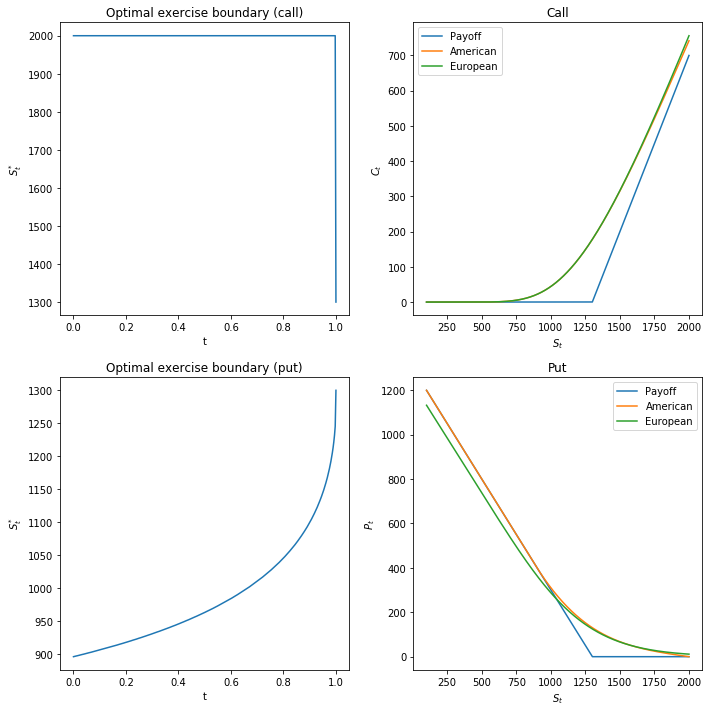

In [5]:
eCall = BMS_price('call', s, K, r, q, sig, T)
ePut = BMS_price('put', s, K, r, q, sig, T)

plt.figure(figsize=(10, 10))

plt.subplot(2, 2, 1)
# calendar time
tmp = np.sort(np.append(K, SxCall))[::-1]
plt.plot(np.append(0, tau), tmp)
plt.xlabel('t')
plt.ylabel('$S^{*}_{t}$')
plt.title('Optimal exercise boundary (call)')
plt.tight_layout()

plt.subplot(2, 2, 2)
plt.plot(s, np.maximum(s - K,0))
plt.plot(s, vCall)
plt.plot(s, eCall);
plt.xlabel('$S_t$')
plt.ylabel('$C_t$')
plt.title('Call')
plt.legend(['Payoff', 'American', 'European'])
plt.tight_layout()

plt.subplot(2, 2, 3)
# calendar time
tmp = np.sort(np.append(K, SxPut))
plt.plot(np.append(0, tau), tmp)
plt.xlabel('t')
plt.ylabel('$S^{*}_{t}$')
plt.title('Optimal exercise boundary (put)')
plt.tight_layout()

plt.subplot(2, 2, 4)
plt.plot(s, np.maximum(K - s,0))
plt.plot(s, vPut)
plt.plot(s, ePut);
plt.xlabel('$S_t$')
plt.ylabel('$P_t$')
plt.title('Put')
plt.legend(['Payoff', 'American', 'European'])
plt.tight_layout()

plt.show()